In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
import tensorflow as tf
from tensorflow import keras   
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input,LSTM,Reshape
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Dropout
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from keras import regularizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
import os
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

Mon May  6 08:55:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
dataset_path = '/kaggle/input/violence-detection-2024/real-life-violence-dataset/real-life-violence-dataset/dataset'
test_path="/kaggle/input/violence-detection-2024/real-life-violence-dataset/real-life-violence-dataset/test"

In [10]:
image_path = '/kaggle/input/violence-detection-2024'

In [11]:
MyDrive = '/kaggle/working'
dataset="/kaggle/input/violence-detection-2024/real-life-violence-dataset/real-life-violence-dataset/dataset"
test_path="/kaggle/input/violence-detection-2024/real-life-violence-dataset/real-life-violence-dataset/test"

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = 224
ColorChannels = 3
batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.28)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    color_mode = "rgb",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    color_mode = "rgb",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
) 
ColorChannels = 3
batch_size = 32


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

Found 25011 images belonging to 2 classes.
Found 9724 images belonging to 2 classes.
Found 4606 images belonging to 2 classes.


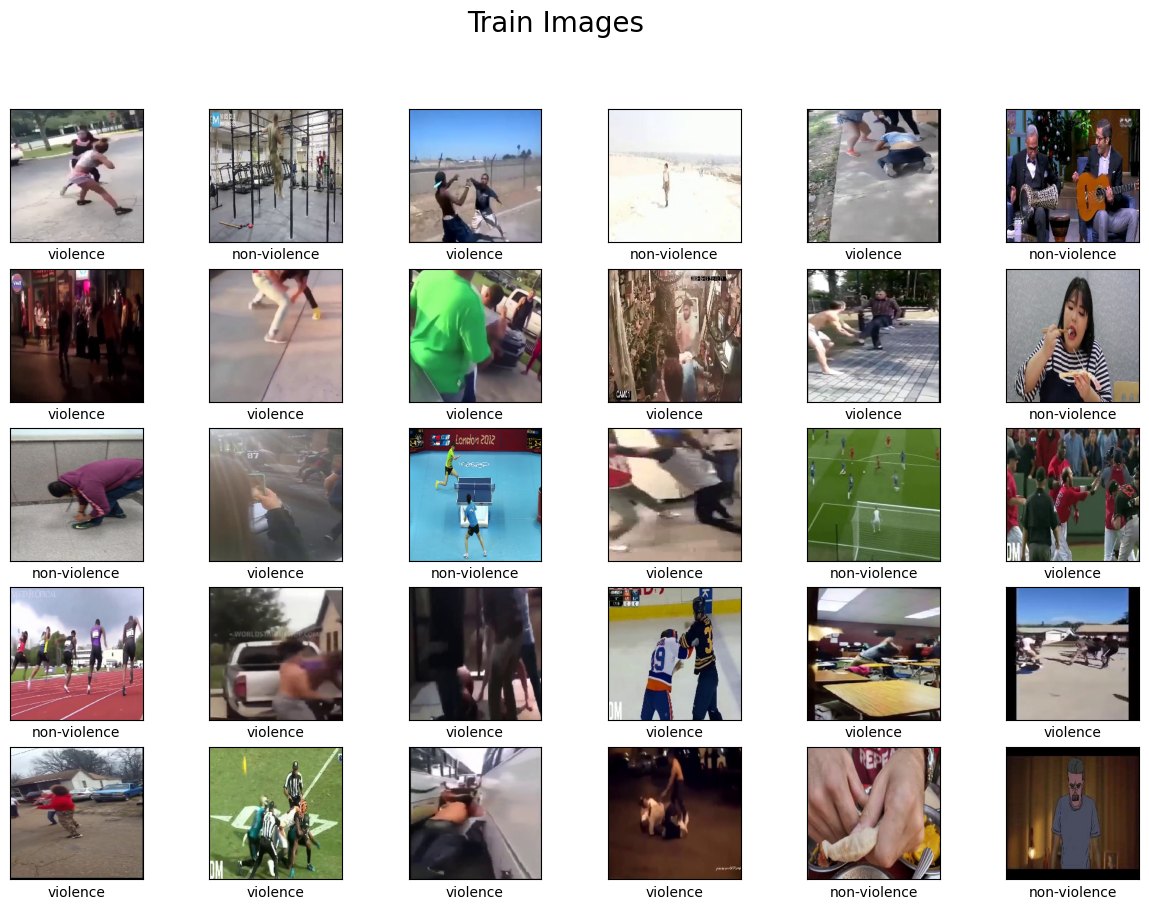

In [13]:

plt.figure(figsize=(15,10))
plt.suptitle("Train Images", fontsize=20)
for i in range(30):
    img, label = train_generator.next()
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if(label[0][0] == 1):
        plt.xlabel("non-violence")
    else:
        plt.xlabel("violence")
    plt.imshow(img[0])

In [14]:

epochs=20
def Inception_model():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel =  InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor,pooling=None)
    for layer in baseModel.layers:
        layer.trainable = False
    headModel = baseModel.output
    headModel = Flatten()(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)

    headModel = Dropout(0.3)(headModel)
    headModel = Reshape((1, -1))(headModel)
    headModel = LSTM(128)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)

    headModel = Dropout(0.2)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)



    return model
if TPU_INIT:
    Imodel = Inception_model()
else:
    Imodel = Inception_model()


87910968/87910968 [==============================] - 0s 0us/step


In [15]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.6,
                                                 patience=20,
                                                min_lr=0.00005,
                                                verbose=1)

In [17]:
checkpoint =ModelCheckpoint("inception.h5", save_best_only=True)

In [18]:
early_stopping =EarlyStopping(patience=20, restore_best_weights=True)

In [19]:
Imodel.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [21]:
history= Imodel.fit(train_generator,
                            epochs=10,
                            validation_data=validation_generator
                           )

Epoch 1/10
782/782 [==============================] - 212s 259ms/step - loss: 0.2022 - accuracy: 0.9228 - val_loss: 0.2449 - val_accuracy: 0.9215
Epoch 2/10
782/782 [==============================] - 113s 144ms/step - loss: 0.0813 - accuracy: 0.9705 - val_loss: 0.1946 - val_accuracy: 0.9347
Epoch 3/10
782/782 [==============================] - 115s 148ms/step - loss: 0.0613 - accuracy: 0.9786 - val_loss: 0.2096 - val_accuracy: 0.9353
Epoch 4/10
782/782 [==============================] - 119s 153ms/step - loss: 0.0472 - accuracy: 0.9828 - val_loss: 0.2491 - val_accuracy: 0.9207
Epoch 5/10
782/782 [==============================] - 113s 145ms/step - loss: 0.0414 - accuracy: 0.9854 - val_loss: 0.2547 - val_accuracy: 0.9319
Epoch 6/10
782/782 [==============================] - 129s 165ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.2478 - val_accuracy: 0.9344
Epoch 7/10
782/782 [==============================] - 222s 284ms/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.2401 -

In [22]:
score,acc=Imodel.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

144/144 [==============================] - 43s 299ms/step - loss: 0.3431 - accuracy: 0.9436
Test Loss = 0.3430562913417816
Test Accuracy = 0.9435518980026245


1/1 [==============================] - 0s 34ms/step


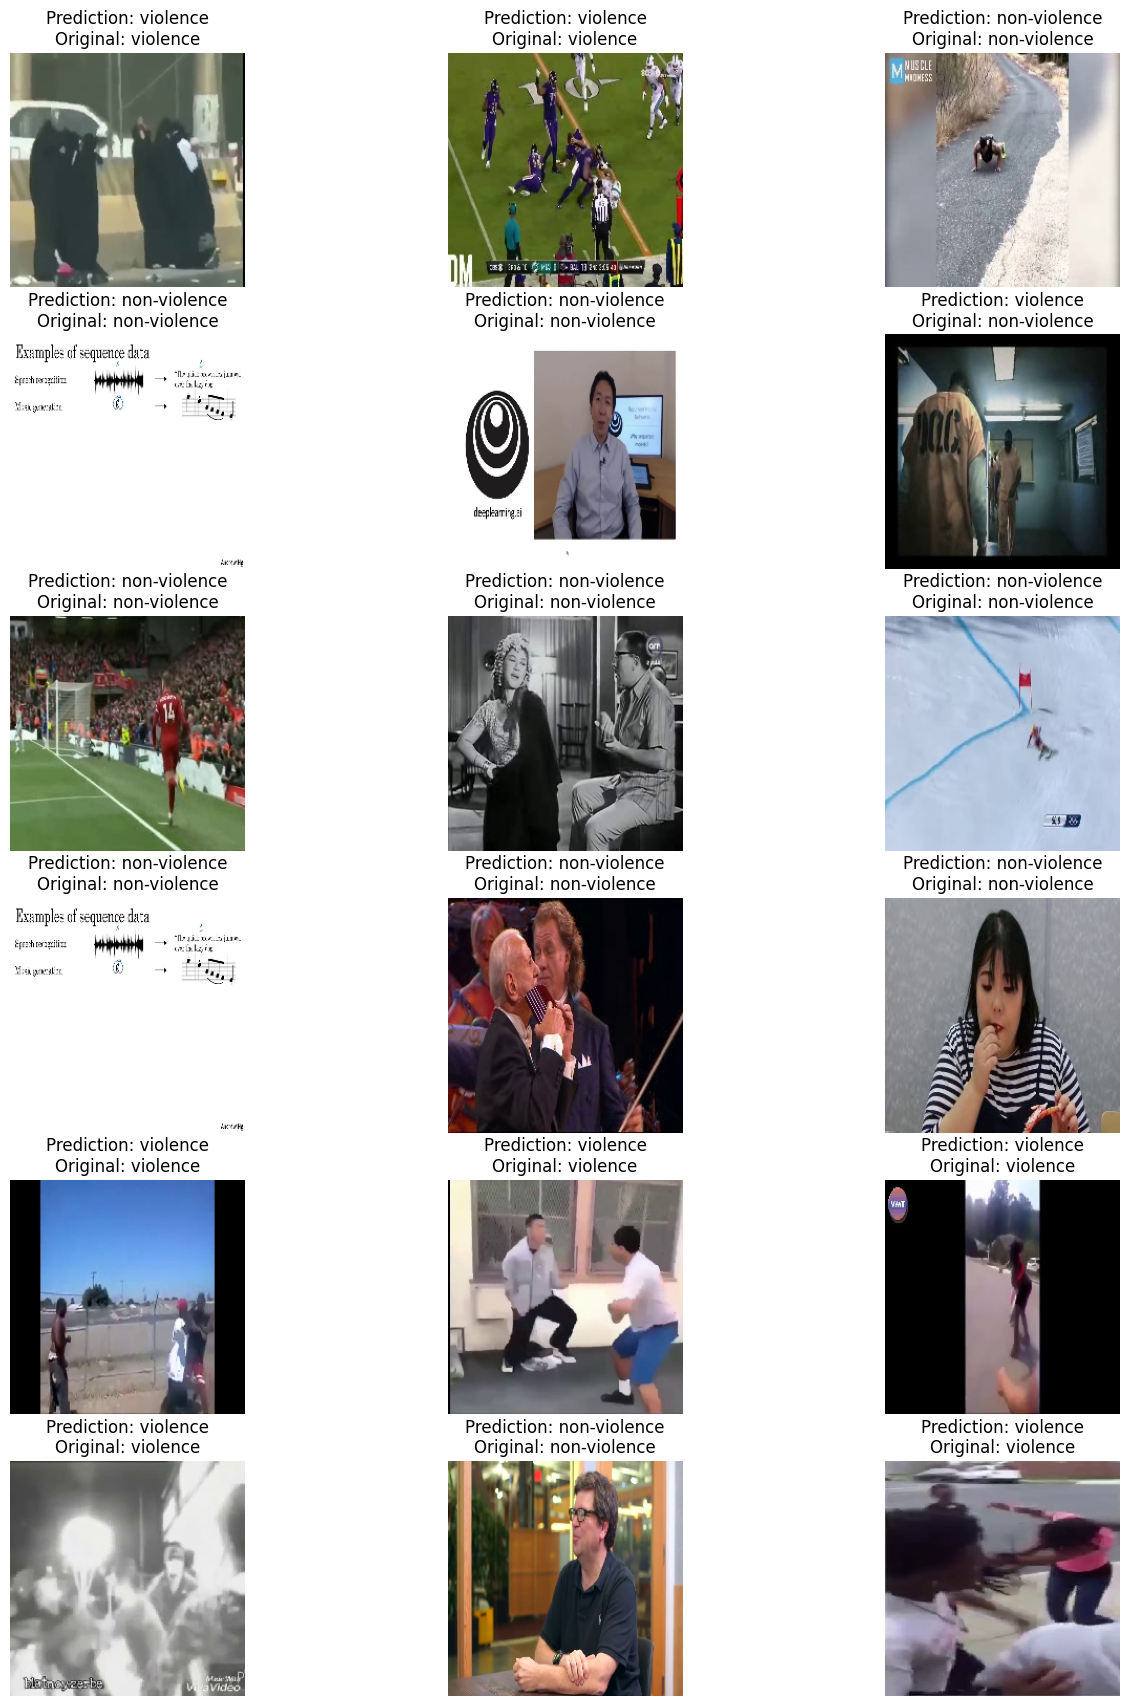

In [23]:
plt.figure(figsize=(16,25))
class_label = ['non-violence' , 'violence']
image, label = test_generator.next()
for i in range(18):
    model_pred = Imodel.predict(image)
    plt.subplot(7,3,i+1)
    plt.imshow(image[i])
    plt.title(f"Prediction: {class_label[tf.argmax(model_pred[i])]}\nOriginal: {class_label[tf.argmax(label[i])]}")
    plt.axis("off")
plt.show()

In [24]:
# Modeli kaydet
tf.saved_model.save(Imodel, "my_model")

# Modeli yükle
loaded_model = tf.saved_model.load("my_model")


In [25]:
# Modeli kaydet
Imodel.save("inception_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
